**<h1 align="center">Predicting the Success of Bank Telemarketing</h1>**
## <center>By: *Boyuan Chen, Qingyuan Chen, Ruiqi Jiang, Yumeng Tang*</center>

**Colab Link**: https://colab.research.google.com/drive/1BFzD6Al5aoIdC99X-aGqR2nq7aXUbOpv#scrollTo=hEcUp7PTsAYu&uniqifier=1

**Table of Contents**
1. [Background](#scrollTo=f1oJBemQAg4D)
2. [Import and Explore the Data](#scrollTo=giAzfujZAldS&line=1&uniqifier=1)

 2.1 [Checking the Data Structure](#scrollTo=nmhUvqxHAxeK)

 2.2 [Data Cleaning & Explanatory Data Analysis](#scrollTo=R_ZPSqEMkW51)
3. [Modeling](#scrollTo=03IVKt-PC2Ra)

 3.1 [Dealing with Data Imbalance](#scrollTo=Klh2iqu6C_oh)

 3.2 [Stacking System Design](#scrollTo=jfOcJ30oDWi2)

 3.3 [Tuning the Base Models](#scrollTo=dF9X8OFGDhQP)

 3.4 [Deploying Random Forest as Meta Classifier](#scrollTo=WUnTrZ9pD_IV)

 3.5 [Tuning the Strong Learner: LightGBM](#scrollTo=GCh593i5EGJl)

 3.6 [Tuning the Strong Learner: XGBoost](#scrollTo=Uwqwj5loEVUZ)

 3.7 [Results of the Winner: LightGBM](#scrollTo=cRDgkN7SEll4)

4. [Model Results & Business Insights](#scrollTo=ctDOT0vhGCq6)

 4.1 [SHAP Summary Plot](#scrollTo=aPaF3Aw7jeZM&line=1&uniqifier=1)

 4.2 [SHAP Scatter Plot](#scrollTo=4KB1XNgajjoO&line=1&uniqifier=1)

5. [Conclusion & Recommendations](#scrollTo=eG1_lz4KjDTO&line=1&uniqifier=1)

# 1. Background

Within the banking industry, optimizing telemarketing strategy is a key issue. The problem addressed in our project is the prediction of the success of telemarketing calls for selling long-term deposits by a Portuguese retail bank. We aim to develop machine learning models to assist bank marketing campaign managers in selecting the most promising customers to contact during their campaigns. By analyzing a dataset spanning from 2008 to 2010, we will focus on feature engineering and the comparison of five machine learning models to determine the most effective approach for predicting campaign success. The goal is to reduce campaign costs, improve customer targeting, and enhance overall marketing campaign efficiency.

# 2. Import and Explore the Data

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

| Column    | Description                                       | Dtype | Null | Variable Type |
|-----------|---------------------------------------------------|-------|------|---------------|
| `job`       | type of job                                       | object| Yes  | Categorical   |
| `marital`   | marital status                                    | object| No   | Categorical   |
| `education` | education level                                   | object| No   | Categorical   |
| `default`   | the situation regarding whether a client has credit in default or not | object| Yes  | Categorical   |
| `housing`   | the situation regarding whether a client has a housing loan or not | object| No   | Categorical   |
| `loan`      | the situation regarding whether a client has a personal loan or not | object| No   | Categorical   |
| `contact`   | communication type for contact                    | object| Yes  | Categorical   |
| `day_of_week` | last contact day of the week                     | int64 | No   | Categorical   |
| `month`     | last contact month of year                        | object| No   | Categorical   |
| `poutcome`  | outcome of the previous marketing campaign        | object| Yes  | Categorical   |
| `age`       | the age of each client                            | int64 | No   | Numerical     |
| `balance`   | average yearly balance                            | int64 | No   | Numerical     |
| `duration`  | last contact duration, in seconds                 | int64 | No   | Numerical     |
| `campaign`  | the number of contacts made during this campaign for each client | int64 | No   | Numerical     |
| `pdays`     | the number of days that passed since each client was last contacted in a previous campaign | int64 | No   | Numerical     |
| `previous`  | the number of contacts made before this campaign for each client | int64 | No   | Numerical     |

##2.1 Checking the Data Structure

In [ ]:
!pip install ucimlrepo
!pip install missingno
!pip install lightgbm
!pip install xgboost
!pip install plotly
!pip install imblearn
!pip install optuna
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 5.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import missingno as mno
from sklearn.model_selection import train_test_split
from tabulate import tabulate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import ADASYN
from ucimlrepo import fetch_ucirepo
from sklearn import set_config
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import optuna
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import shap

In [ ]:
# fetch dataset
bank_marketing = fetch_ucirepo(id=222)

# data (as pandas dataframes)
X = bank_marketing.data.features
y = bank_marketing.data.targets

# metadata
print(bank_marketing.metadata)

# variable information
print(bank_marketing.variables)

{'uci_id': 222, 'name': 'Bank Marketing', 'repository_url': 'https://archive.ics.uci.edu/dataset/222/bank+marketing', 'data_url': 'https://archive.ics.uci.edu/static/public/222/data.csv', 'abstract': 'The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 45211, 'num_features': 16, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Occupation', 'Marital Status', 'Education Level'], 'target_col': ['y'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2014, 'last_updated': 'Fri Aug 18 2023', 'dataset_doi': '10.24432/C5K306', 'creators': ['S. Moro', 'P. Rita', 'P. Cortez'], 'intro_paper': {'title': 'A data-driven approach to predict the success of bank telemarketing'

In [ ]:
X

age           job   marital  education default  balance housing loan  \
0       58    management   married   tertiary      no     2143     yes   no   
1       44    technician    single  secondary      no       29     yes   no   
2       33  entrepreneur   married  secondary      no        2     yes  yes   
3       47   blue-collar   married        NaN      no     1506     yes   no   
4       33           NaN    single        NaN      no        1      no   no   
...    ...           ...       ...        ...     ...      ...     ...  ...   
45206   51    technician   married   tertiary      no      825      no   no   
45207   71       retired  divorced    primary      no     1729      no   no   
45208   72       retired   married  secondary      no     5715      no   no   
45209   57   blue-collar   married  secondary      no      668      no   no   
45210   37  entrepreneur   married  secondary      no     2971      no   no   

         contact  day_of_week month  duration  campaign  pdays  previous  \
0            NaN            5   may       261         1     -1         0   
1            NaN            5   may       151         1     -1         0   
2            NaN            5   may        76         1     -1         0   
3            NaN            5   may        92         1     -1         0   
4            NaN            5   may       198         1     -1         0   
...          ...          ...   ...       ...       ...    ...       ...   
45206   cellular           17   nov       977         3     -1         0   
45207   cellular           17   nov       456         2     -1         0   
45208   cellular           17   nov      1127         5    184         3   
45209  telephone           17   nov       508         4     -1         0   
45210   cellular           17   nov       361         2    188        11   

      poutcome  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  
...        ...  
45206      NaN  
45207      NaN  
45208  success  
45209      NaN  
45210    other  

[45211 rows x 16 columns]

In [ ]:
y

y
0       no
1       no
2       no
3       no
4       no
...    ...
45206  yes
45207  yes
45208  yes
45209   no
45210   no

[45211 rows x 1 columns]

In [ ]:
X['y'] = y
X

age           job   marital  education default  balance housing loan  \
0       58    management   married   tertiary      no     2143     yes   no   
1       44    technician    single  secondary      no       29     yes   no   
2       33  entrepreneur   married  secondary      no        2     yes  yes   
3       47   blue-collar   married        NaN      no     1506     yes   no   
4       33           NaN    single        NaN      no        1      no   no   
...    ...           ...       ...        ...     ...      ...     ...  ...   
45206   51    technician   married   tertiary      no      825      no   no   
45207   71       retired  divorced    primary      no     1729      no   no   
45208   72       retired   married  secondary      no     5715      no   no   
45209   57   blue-collar   married  secondary      no      668      no   no   
45210   37  entrepreneur   married  secondary      no     2971      no   no   

         contact  day_of_week month  duration  campaign  pdays  previous  \
0            NaN            5   may       261         1     -1         0   
1            NaN            5   may       151         1     -1         0   
2            NaN            5   may        76         1     -1         0   
3            NaN            5   may        92         1     -1         0   
4            NaN            5   may       198         1     -1         0   
...          ...          ...   ...       ...       ...    ...       ...   
45206   cellular           17   nov       977         3     -1         0   
45207   cellular           17   nov       456         2     -1         0   
45208   cellular           17   nov      1127         5    184         3   
45209  telephone           17   nov       508         4     -1         0   
45210   cellular           17   nov       361         2    188        11   

      poutcome    y  
0          NaN   no  
1          NaN   no  
2          NaN   no  
3          NaN   no  
4          NaN   no  
...        ...  ...  
45206      NaN  yes  
45207      NaN  yes  
45208  success  yes  
45209      NaN   no  
45210    other   no  

[45211 rows x 17 columns]

In [ ]:
df = X.copy()
df

age           job   marital  education default  balance housing loan  \
0       58    management   married   tertiary      no     2143     yes   no   
1       44    technician    single  secondary      no       29     yes   no   
2       33  entrepreneur   married  secondary      no        2     yes  yes   
3       47   blue-collar   married        NaN      no     1506     yes   no   
4       33           NaN    single        NaN      no        1      no   no   
...    ...           ...       ...        ...     ...      ...     ...  ...   
45206   51    technician   married   tertiary      no      825      no   no   
45207   71       retired  divorced    primary      no     1729      no   no   
45208   72       retired   married  secondary      no     5715      no   no   
45209   57   blue-collar   married  secondary      no      668      no   no   
45210   37  entrepreneur   married  secondary      no     2971      no   no   

         contact  day_of_week month  duration  campaign  pdays  previous  \
0            NaN            5   may       261         1     -1         0   
1            NaN            5   may       151         1     -1         0   
2            NaN            5   may        76         1     -1         0   
3            NaN            5   may        92         1     -1         0   
4            NaN            5   may       198         1     -1         0   
...          ...          ...   ...       ...       ...    ...       ...   
45206   cellular           17   nov       977         3     -1         0   
45207   cellular           17   nov       456         2     -1         0   
45208   cellular           17   nov      1127         5    184         3   
45209  telephone           17   nov       508         4     -1         0   
45210   cellular           17   nov       361         2    188        11   

      poutcome    y  
0          NaN   no  
1          NaN   no  
2          NaN   no  
3          NaN   no  
4          NaN   no  
...        ...  ...  
45206      NaN  yes  
45207      NaN  yes  
45208  success  yes  
45209      NaN   no  
45210    other   no  

[45211 rows x 17 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  duration     45211 non-null  int64 
 12  campaign     45211 non-null  int64 
 13  pdays        45211 non-null  int64 
 14  previous     45211 non-null  int64 
 15  poutcome     8252 non-null   object
 16  y            45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [ ]:
df.describe()

age        balance   day_of_week      duration      campaign  \
count  45211.000000   45211.000000  45211.000000  45211.000000  45211.000000   
mean      40.936210    1362.272058     15.806419    258.163080      2.763841   
std       10.618762    3044.765829      8.322476    257.527812      3.098021   
min       18.000000   -8019.000000      1.000000      0.000000      1.000000   
25%       33.000000      72.000000      8.000000    103.000000      1.000000   
50%       39.000000     448.000000     16.000000    180.000000      2.000000   
75%       48.000000    1428.000000     21.000000    319.000000      3.000000   
max       95.000000  102127.000000     31.000000   4918.000000     63.000000   

              pdays      previous  
count  45211.000000  45211.000000  
mean      40.197828      0.580323  
std      100.128746      2.303441  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000      0.000000  
75%       -1.000000      0.000000  
max      871.000000    275.000000

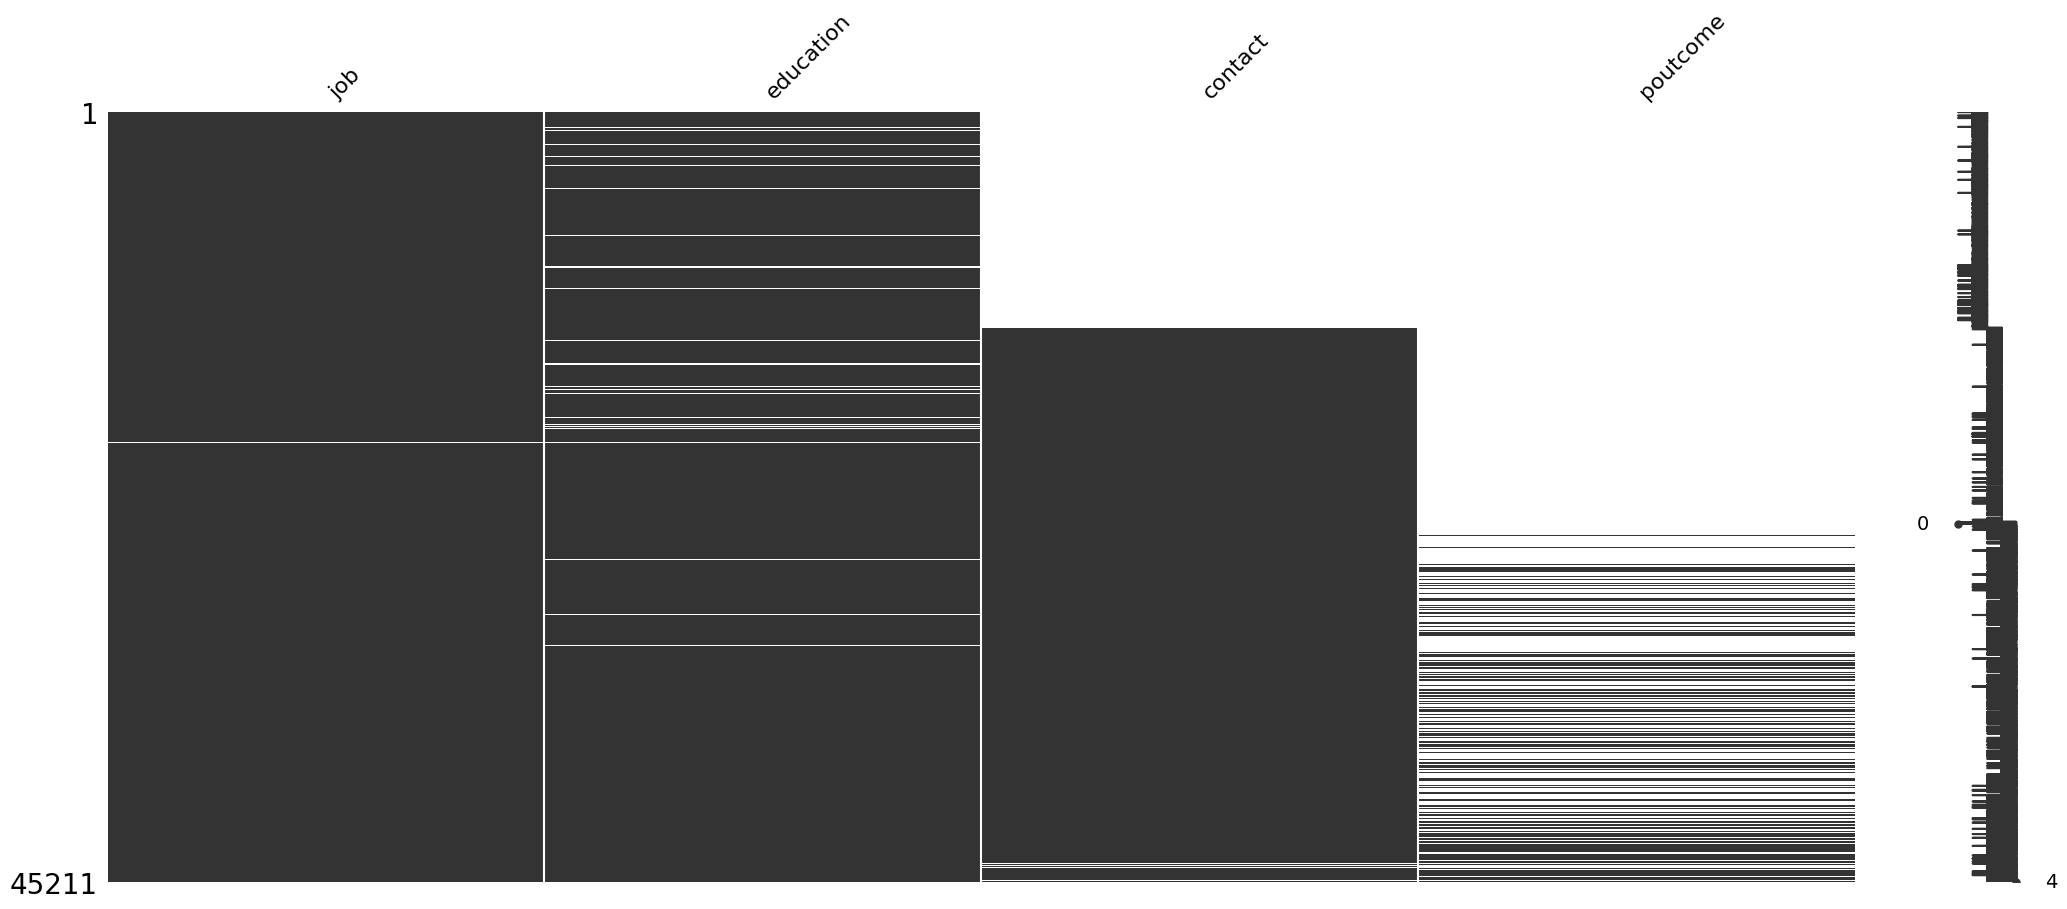

In [ ]:
mno.matrix(df.loc[:, df.isna().any()], color = '0.2')
plt.show()

##2.2 Data Cleaning & Explanatory Data Analysis

### Cleaning

Depending on the table of variables provided by the data source, we chose several different methods to deal with the missing values within different variables.

For **jobs**, **education**, and **contact**, where unknown values do not provide valid analytical meaning, we chose to drop all rows containing unknown values; for **poutcome**, where non-successful analytical meaning is equivalent to failure, we chose to convert all other and unknown values to failure.

In [ ]:
# Drop null value for job, education & contact
df1 = df.dropna(subset=['job', 'education', 'contact'])
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30907 entries, 12657 to 45210
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          30907 non-null  int64 
 1   job          30907 non-null  object
 2   marital      30907 non-null  object
 3   education    30907 non-null  object
 4   default      30907 non-null  object
 5   balance      30907 non-null  int64 
 6   housing      30907 non-null  object
 7   loan         30907 non-null  object
 8   contact      30907 non-null  object
 9   day_of_week  30907 non-null  int64 
 10  month        30907 non-null  object
 11  duration     30907 non-null  int64 
 12  campaign     30907 non-null  int64 
 13  pdays        30907 non-null  int64 
 14  previous     30907 non-null  int64 
 15  poutcome     7842 non-null   object
 16  y            30907 non-null  object
dtypes: int64(7), object(10)
memory usage: 4.2+ MB


In [ ]:
# Convert other and unknown in poutcome to failure
print(df1['poutcome'].unique())
df1[['poutcome']] = df1[['poutcome']].fillna('other')
df1['poutcome'] = df1['poutcome'].replace('other', 'failure')
print(df1['poutcome'].unique())

[nan 'failure' 'other' 'success']
['failure' 'success']



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


By examining the unique values and their quantities in all columns, we find that *yes* and *no* in **y** can be converted to 1 and 0 for subsequent analysis and operations. In addition, we found that the **pdays** variable had too many *-1* values, i.e., not previously contacted. This value can have a negative impact on building a model for analysis, so we treated all *-1* as a *0* and any value positive as a *1*, treating it as a categorical variable **pcontact**. This way it also works better with the variable **previous**.

In [ ]:
# Create a mapping to convert yes and no to 1 and 0
mapping = {'yes': 1, 'no': 0}
df1['y'] = df1['y'].map(mapping)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# Convert numeric variable pdays to categorical variable pcontact
count = (df['pdays'] == -1).sum()
print(count)
df1['pcontact'] = df1['pdays'].apply(lambda x: 0 if x == -1 else 1)
df1.drop('pdays', axis=1, inplace=True)
df1.head()

36954



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


age          job  marital  education default  balance housing loan  \
12657   27   management   single  secondary      no       35      no   no   
12658   54  blue-collar  married    primary      no      466      no   no   
12659   43  blue-collar  married  secondary      no      105      no  yes   
12660   31   technician   single  secondary      no       19      no   no   
12661   27   technician   single  secondary      no      126     yes  yes   

         contact  day_of_week month  duration  campaign  previous poutcome  y  \
12657   cellular            4   jul       255         1         0  failure  0   
12658   cellular            4   jul       297         1         0  failure  0   
12659   cellular            4   jul       668         2         0  failure  0   
12660  telephone            4   jul        65         2         0  failure  0   
12661   cellular            4   jul       436         4         0  failure  0   

       pcontact  
12657         0  
12658         0  
12659         0  
12660         0  
12661         0

### Train-test Split & Explanatory Data Analysis

In [ ]:
# Train-test Split
X1 = df1.drop('y', axis=1)
y1 = df1['y']

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.3, random_state=42)

In [ ]:
y_test.value_counts() / len(y_test)

0    0.856896
1    0.143104
Name: y, dtype: float64

In [ ]:
y_test.shape

(9273,)

In [ ]:
y_train.value_counts() / len(y_train)

0    0.852732
1    0.147268
Name: y, dtype: float64

In [ ]:
ytrain_df = pd.DataFrame(y_train, columns=['y'])

class_counts = ytrain_df['y'].value_counts().reset_index()
fig = px.bar(class_counts,
             x='index',
             y='y',
             labels={'index': 'Class', 'y': 'Count'},
             title='Class Distribution in Training Data',
             color='index',
             color_discrete_map={'yes': 'blue', 'no': 'red'})
fig.show()

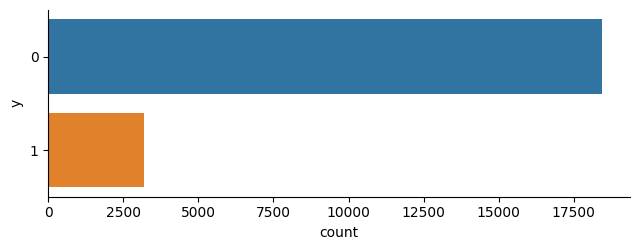

In [ ]:
ytrain_df = pd.DataFrame(y_train).reset_index(drop=True)
ax = sns.catplot(y="y", kind="count", data=ytrain_df, height=2.6, aspect=2.5)

From observing the ratio of successes against failures, we may conclude that it is a highly imbalanced dataset, which need subsequent oversampling to deal with this problem.

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30907 entries, 12657 to 45210
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          30907 non-null  int64 
 1   job          30907 non-null  object
 2   marital      30907 non-null  object
 3   education    30907 non-null  object
 4   default      30907 non-null  object
 5   balance      30907 non-null  int64 
 6   housing      30907 non-null  object
 7   loan         30907 non-null  object
 8   contact      30907 non-null  object
 9   day_of_week  30907 non-null  int64 
 10  month        30907 non-null  object
 11  duration     30907 non-null  int64 
 12  campaign     30907 non-null  int64 
 13  previous     30907 non-null  int64 
 14  poutcome     30907 non-null  object
 15  y            30907 non-null  int64 
 16  pcontact     30907 non-null  int64 
dtypes: int64(8), object(9)
memory usage: 4.2+ MB


In [ ]:
Xtrain_df = X_train.reset_index(drop=True)
Xtrain_df.head()

age          job  marital  education default  balance housing loan  \
0   37  blue-collar  married  secondary      no      236      no   no   
1   35   technician   single   tertiary      no     1880      no   no   
2   30   management   single   tertiary      no       57     yes   no   
3   30     services  married  secondary      no     4867     yes  yes   
4   23  blue-collar   single  secondary      no      668     yes   no   

     contact  day_of_week month  duration  campaign  previous poutcome  \
0   cellular           25   jul       438         6         0  failure   
1   cellular           20   may       154         1         0  failure   
2   cellular            4   feb       153         2         0  failure   
3  telephone           20   apr         8         6         3  failure   
4   cellular           18   may       857         3         0  failure   

   pcontact  
0         0  
1         0  
2         0  
3         1  
4         0

In [ ]:
# Heatmap of all numeric features
corr_matrix = Xtrain_df.corr()
fig = px.imshow(corr_matrix, text_auto=True, aspect="auto", color_continuous_scale='RdBu_r', title="Heatmap of Correlation Matrix")
fig.update_xaxes(side="bottom")
fig.show()

<ipython-input-19-b59041de58c7>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = Xtrain_df.corr()


Except for the two variables produced by the processing, **pcontact** and **previous**, which have a strong correlation, the correlation of all the other features is not strong, which is a good thing. The reason these two variables are correlated is that **pcontact** represents whether or not there has been previous contact, while **previous** represents the number of previous contacts, which means that previous will only have a value that is not 0 if pcontact is 1.

In [ ]:
# The relationship between balance and housing, color by loan
fig = px.box(df, y='balance', x='housing', color='loan',
             title='Balance Distribution with Housing and Loan Status',
             category_orders={"housing": ["yes", "no"], "loan": ["yes", "no"]},
             labels={'balance':'Balance', 'housing':'Housing', 'loan':'Loan'})

fig.update_layout(yaxis_title='Balance', xaxis_title='Housing Status', legend_title='Loan Status')
fig.show()

In [ ]:
# The rank of highest job types
fig = px.histogram(Xtrain_df, x='job', color='poutcome', barmode='group', title='Count of Outcome by Job Type', labels={'poutcome':'Outcome', 'job':'Job Type'},
                   category_orders={"poutcome": ["failure", "success"]})
fig.update_layout(xaxis_title="Job Type", yaxis_title="Count", legend_title="Outcome", xaxis={'categoryorder':'total descending'})
fig.show()

In [ ]:
# Age distribution
fig = px.histogram(Xtrain_df, x='age', title='Distribution of Age', marginal='box', nbins=30, color_discrete_sequence=['#636EFA'])
fig.update_layout(bargap=0.1)
fig.show()

In [ ]:
# Distribution of balance
fig = px.histogram(Xtrain_df, x='balance', title='Distribution of Balance', marginal='box', nbins=30, color_discrete_sequence=['#636EFA'])
fig.update_layout(bargap=0.1)
fig.show()

It's worth noting that there are a lot of clients whose balance is not in good shape, or even negative. The explanation would be interesting after model fitting.

In [ ]:
# Percentage of marital situation
fig = px.pie(Xtrain_df, names='marital',
             title='Distribution of Marital Status',
             color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_traces(textinfo='percent+label', pull=[0.1 if i == 0 else 0 for i in range(len(df['marital'].unique()))])
fig.show()

In [ ]:
# Percentage of education situation
fig = px.pie(Xtrain_df, names='education',
             title='Distribution of Education',
             color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_traces(textinfo='percent+label', pull=[0.1 if i == 0 else 0 for i in range(len(df['marital'].unique()))])
fig.show()

We may noticed that the majority **(over 50%)** of clients are married and have secondary education.

In [ ]:
# (Lack of) dependence between age and outcome
fig = px.violin(Xtrain_df, y='age', x='poutcome', color='poutcome', box=True, points="all", title='Age Distribution by Outcome')
fig.update_layout(yaxis_title="Age", xaxis_title="Outcome")
fig.show()

#3. Modeling

## 3.1 Dealing with data imbalance

In this phase, since we are aware of the potential problem generated by imbalanced dataset, we import ADASYN for oversampling, preprocess our training dataset, and handle both numeric and categorical features. We use a preprocessing pipeline to transform the training data and create a feature map to track the transformed features. Next, we use ADASYN to balance our dataset by oversampling the minority class, generating a more balanced set of training data which is crucial for effective model training, especially in cases of class imbalance.

In [ ]:
Xtrain_df = Xtrain_df.rename(columns={'day_of_week': 'day_of_month'})

In [ ]:
set_config(display='diagram')

# Identify numeric and categorical columns
numeric_cols = ['age', 'balance', 'duration', 'campaign', 'pcontact', 'previous', 'day_of_month']
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

preprocess_pipeline = ColumnTransformer([
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(drop="first"), categorical_cols)])
preprocess_pipeline

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['age', 'balance', 'duration', 'campaign',
                                  'pcontact', 'previous', 'day_of_month']),
                                ('cat', OneHotEncoder(drop='first'),
                                 ['job', 'marital', 'education', 'default',
                                  'housing', 'loan', 'contact', 'month',
                                  'poutcome'])])

In [ ]:
train_df = pd.concat([Xtrain_df, ytrain_df], axis=1)
train_df

age            job  marital  education default  balance housing loan  \
0       37    blue-collar  married  secondary      no      236      no   no   
1       35     technician   single   tertiary      no     1880      no   no   
2       30     management   single   tertiary      no       57     yes   no   
3       30       services  married  secondary      no     4867     yes  yes   
4       23    blue-collar   single  secondary      no      668     yes   no   
...    ...            ...      ...        ...     ...      ...     ...  ...   
21629   29     management  married   tertiary      no     8103      no   no   
21630   34     management  married   tertiary      no       82      no   no   
21631   37  self-employed  married   tertiary      no     1146      no  yes   
21632   30         admin.   single   tertiary      no      267      no   no   
21633   31         admin.  married  secondary      no      879     yes   no   

         contact  day_of_month month  duration  campaign  previous poutcome  \
0       cellular            25   jul       438         6         0  failure   
1       cellular            20   may       154         1         0  failure   
2       cellular             4   feb       153         2         0  failure   
3      telephone            20   apr         8         6         3  failure   
4       cellular            18   may       857         3         0  failure   
...          ...           ...   ...       ...       ...       ...      ...   
21629   cellular            28   may       473         3         0  failure   
21630   cellular            31   jul       134         5         0  failure   
21631   cellular             9   jul        80         1         0  failure   
21632   cellular             2   feb       124         1         0  failure   
21633   cellular            13   may       394         1         0  failure   

       pcontact  y  
0             0  0  
1             0  1  
2             0  0  
3             1  0  
4             0  0  
...         ... ..  
21629         0  1  
21630         0  0  
21631         0  0  
21632         0  0  
21633         0  1  

[21634 rows x 17 columns]

In [ ]:
X_train_processed = preprocess_pipeline.fit_transform(Xtrain_df)

In [ ]:
print(type(X_train_processed))
print(X_train_processed.shape)

<class 'numpy.ndarray'>
(21634, 37)


In [ ]:
# Numeric features remain the same
feature_map = {i: col for i, col in enumerate(numeric_cols)}

# Get the one-hot encoded feature names
ohe_feature_names = preprocess_pipeline.named_transformers_['cat'].get_feature_names_out()

# Add the one-hot encoded features to the map
offset = len(numeric_cols)
for i, feature_name in enumerate(ohe_feature_names):
    feature_map[i + offset] = feature_name

In [ ]:
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X_train_processed, ytrain_df.values.ravel())

## 3.2 Stacking System Design

Next, we are setting up a feature selection and model evaluation process for 4 base models including Logistic Regression, SVC, Decision Tree, Gradient Boosting, and two stong learners LightGBM and XGBoost. We import necessary libraries and establish a model dictionary to hold our model configurations. We used stratified K-Fold cross-validation, an essential step to ensure balanced model assessment. We then initiate a backward feature selection loop for each model in our dictionary, where we start with all features and iteratively remove the least important one, assessed through the model's feature importances or coefficients. This iterative process ensures a minimum of 10 features are retained, and the model's performance is continuously evaluated to track the best score and corresponding feature set.

In [ ]:
set_config(display='diagram')

models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'GradientBoost': GradientBoostingClassifier(),
    'RandomForest': RandomForestClassifier(),
    'SVC': SVC(kernel='linear'),
    'LightGBM': LGBMClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Function to evaluate the model using Stratified K-Fold cross-validation
def evaluate_model(model, X, y, scoring='accuracy'):
    cv = StratifiedKFold(n_splits=5)
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    return np.mean(scores)

# Perform feature selection and evaluation
for model_name, model in models.items():
    print(f"Processing {model_name}...")
    num_features = X_resampled.shape[1]
    feature_indices = list(range(num_features))
    best_score = 0
    best_features_indices = []

    while len(feature_indices) >= 10:  # Ensure at least 10 features
        X_train_selected = X_resampled[:, feature_indices]
        pipeline = Pipeline([('model', model)])
        score = evaluate_model(pipeline, X_train_selected, y_resampled)

        if score > best_score:
            best_score = score
            best_features_indices = list(feature_indices)

        pipeline.fit(X_train_selected, y_resampled)

        # Retrieve feature importances or coefficients
        if model_name in ['RandomForest', 'LightGBM', 'XGBoost', 'GradientBoost']:
            importances = pipeline.named_steps['model'].feature_importances_
        elif model_name in ['LogisticRegression', 'SVC']:
            importances = np.abs(pipeline.named_steps['model'].coef_[0])

        # Sort features by importance and remove the least important
        feature_importances = dict(zip(feature_indices, importances))
        least_important = min(feature_importances, key=feature_importances.get)
        feature_indices.remove(least_important)

    # Map feature indices back to feature names
    best_feature_names = [feature_map[i] for i in best_features_indices]
    print(f"{model_name} - Best Score: {best_score}, Best Features: {best_feature_names}\n")

Processing LogisticRegression...
LogisticRegression - Best Score: 0.8139067439345744, Best Features: ['balance', 'duration', 'campaign', 'pcontact', 'previous', 'day_of_month', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'marital_married', 'marital_single', 'education_secondary', 'education_tertiary', 'default_yes', 'housing_yes', 'loan_yes', 'contact_telephone', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_success']

Processing GradientBoost...
GradientBoost - Best Score: 0.8883231860467307, Best Features: ['age', 'balance', 'duration', 'campaign', 'day_of_month', 'job_blue-collar', 'marital_married', 'housing_yes', 'loan_yes', 'contact_telephone', 'month_aug', 'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov

In [ ]:
# Decision Tree model
model = DecisionTreeClassifier()

# Function to evaluate the model using Stratified K-Fold cross-validation
def evaluate_model(model, X, y, scoring='accuracy'):
    cv = StratifiedKFold(n_splits=5)
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    return np.mean(scores)

# Initialize variables for tracking the best score and best features
best_score = 0
best_features_indices = []

# Start with all features
num_features = X_resampled.shape[1]
feature_indices = list(range(num_features))

# Feature selection process
while len(feature_indices) >= 10:  # Ensure at least 10 features
    X_train_selected = X_resampled[:, feature_indices]
    score = evaluate_model(model, X_train_selected, y_resampled)

    if score > best_score:
        best_score = score
        best_features_indices = list(feature_indices)

    model.fit(X_train_selected, y_resampled)

    # Retrieve feature importances
    importances = model.feature_importances_

    # Sort features by importance and remove the least important
    feature_importances = dict(zip(feature_indices, importances))
    least_important = min(feature_importances, key=feature_importances.get)
    feature_indices.remove(least_important)

# Map feature indices back to feature names
best_feature_names = [feature_map[i] for i in best_features_indices]
print(f"Decision Tree - Best Score: {best_score}, Best Features: {best_feature_names}\n")

Decision Tree - Best Score: 0.8764063036345824, Best Features: ['age', 'balance', 'duration', 'campaign', 'pcontact', 'previous', 'day_of_month', 'job_blue-collar', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'marital_married', 'marital_single', 'education_secondary', 'education_tertiary', 'housing_yes', 'loan_yes', 'contact_telephone', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_success']



Here we're preparing for the tuning of four base models (Decision Tree, Logistic Regression, Gradient Boosting, and SVC) and the design of a stacking model by storing the best features for each base model. The feature lists for each model, encompassing a range of demographic and financial attributes, are crucial for model optimization.

We then manually map these features in our feature_map, integrating numeric and one-hot encoded categorical features.

In [ ]:
best_features_dt = ['age', 'balance', 'duration', 'campaign', 'pcontact', 'previous', 'day_of_month',
                    'job_blue-collar', 'job_management', 'job_retired', 'job_self-employed', 'job_services',
                    'job_student', 'job_technician', 'job_unemployed', 'marital_married', 'marital_single',
                    'education_secondary', 'education_tertiary', 'housing_yes', 'loan_yes', 'contact_telephone',
                    'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar',
                    'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_success']

best_features_lr = ['balance', 'duration', 'campaign', 'pcontact', 'previous', 'day_of_month',
                    'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
                    'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed',
                    'marital_married', 'marital_single', 'education_secondary', 'education_tertiary',
                    'default_yes', 'housing_yes', 'loan_yes', 'contact_telephone', 'month_aug', 'month_dec',
                    'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov',
                    'month_oct', 'month_sep', 'poutcome_success']

best_features_gb = ['age', 'balance', 'duration', 'campaign', 'day_of_month', 'job_blue-collar', 'marital_married',
                    'housing_yes', 'loan_yes', 'contact_telephone', 'month_aug', 'month_feb', 'month_jan',
                    'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'poutcome_success']

best_features_svc = ['duration', 'campaign', 'previous', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
                     'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student',
                     'job_technician', 'job_unemployed', 'marital_single', 'education_secondary', 'education_tertiary',
                     'default_yes', 'housing_yes', 'loan_yes', 'contact_telephone', 'month_aug', 'month_dec',
                     'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov',
                     'month_oct', 'month_sep', 'poutcome_success']

In [ ]:
# Ensure feature_map is correctly populated with all the transformed feature names
feature_map = {i: col for i, col in enumerate(numeric_cols)}

# Get the one-hot encoded feature names
ohe_feature_names = preprocess_pipeline.named_transformers_['cat'].get_feature_names_out()

# Add the one-hot encoded features to the map
offset = len(numeric_cols)
for i, feature_name in enumerate(ohe_feature_names):
    feature_map[i + offset] = feature_name

# Check the feature map
print(feature_map)

{0: 'age', 1: 'balance', 2: 'duration', 3: 'campaign', 4: 'pcontact', 5: 'previous', 6: 'day_of_month', 7: 'job_blue-collar', 8: 'job_entrepreneur', 9: 'job_housemaid', 10: 'job_management', 11: 'job_retired', 12: 'job_self-employed', 13: 'job_services', 14: 'job_student', 15: 'job_technician', 16: 'job_unemployed', 17: 'marital_married', 18: 'marital_single', 19: 'education_secondary', 20: 'education_tertiary', 21: 'default_yes', 22: 'housing_yes', 23: 'loan_yes', 24: 'contact_telephone', 25: 'month_aug', 26: 'month_dec', 27: 'month_feb', 28: 'month_jan', 29: 'month_jul', 30: 'month_jun', 31: 'month_mar', 32: 'month_may', 33: 'month_nov', 34: 'month_oct', 35: 'month_sep', 36: 'poutcome_success'}


## 3.3 Tuning the base models

In this code block, we did hyperparameter tuning for four base models (SVC, Logistic Regression, Decision Tree, and Gradient Boosting) using Optuna.

We start by selecting the best features for each model and preparing respective subsets of the resampled dataset. For each model, we define an objective function specifying the hyperparameter search space and use cross-validation for performance evaluation. This thorough tuning ensures that our base models are optimally configured, which is beneficial for the design of a high-performing stacking model.

In [ ]:
print(X_resampled.shape)

(37089, 37)


In [ ]:
# Start with an empty list for indices
svc_feature_indices = []

# Manually add features from best_features_svc
for feature in best_features_svc:
    if feature in feature_map.values():
        index = list(feature_map.keys())[list(feature_map.values()).index(feature)]
        svc_feature_indices.append(index)
    else:
        print(f"Feature {feature} not found in feature_map")

# Now use these indices to create X_svc
X_svc = X_resampled[:, svc_feature_indices]

# Check the shape of X_svc
print(X_svc.shape)

(37089, 32)


In [ ]:
def objective_svc(trial):
    params = {
        'C': trial.suggest_loguniform('C', 1e-3, 1e3),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'sigmoid']),
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto'])
    }
    model = SVC(**params)
    score = cross_val_score(model, X_svc, y_resampled, n_jobs=-1, cv=StratifiedKFold(5)).mean()
    return score

# Create a study object and optimize the objective function
study_svc = optuna.create_study(direction='maximize')
study_svc.optimize(objective_svc, n_trials=50)  # Adjust the number of trials as needed

print("Best Parameters for SVC:", study_svc.best_params)

[I 2023-12-02 02:54:58,604] A new study created in memory with name: no-name-e47c6314-6b56-441b-9cf0-85d4ace70ef1
/var/tmp/ipykernel_4835/84278030.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-3, 1e3),
[I 2023-12-02 02:55:56,952] Trial 0 finished with value: 0.8175197120807013 and parameters: {'C': 0.01943838380632556, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 0 with value: 0.8175197120807013.
/var/tmp/ipykernel_4835/84278030.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-3, 1e3),
[I 2023-12-02 02:57:39,284] Trial 1 finished with value: 0.8162794056326337 and parameters: {'

Best Parameters for SVC: {'C': 342.60613310749403, 'kernel': 'rbf', 'gamma': 'scale'}


In [ ]:
lr_feature_indices = []

# Manually add features from best_features_lr
for feature in best_features_lr:
    if feature in feature_map.values():
        index = list(feature_map.keys())[list(feature_map.values()).index(feature)]
        lr_feature_indices.append(index)
    else:
        print(f"Feature {feature} not found in feature_map")

# Debug: print the collected indices
print("Collected feature indices for LR:", lr_feature_indices)

# Now use these indices to create X_lr
X_lr = X_resampled[:, lr_feature_indices]

# Check the shape of X_lr
print("Shape of X_lr:", X_lr.shape)

Collected feature indices for LR: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]
Shape of X_lr: (37089, 36)


In [ ]:
def objective_lr(trial):
    params = {
        'C': trial.suggest_loguniform('C', 1e-4, 1e4),
        'solver': trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
        'max_iter': trial.suggest_int('max_iter', 100, 1000)
    }
    model = LogisticRegression(**params)
    score = cross_val_score(model, X_lr, y_resampled, n_jobs=-1, cv=StratifiedKFold(5)).mean()
    return score

# Create a study object and optimize the objective function
study_lr = optuna.create_study(direction='maximize')
study_lr.optimize(objective_lr, n_trials=50)  # Adjust the number of trials as needed

print("Best Parameters for Logistic Regression:", study_lr.best_params)

[I 2023-12-02 20:24:47,174] A new study created in memory with name: no-name-2be9e3ed-f6b8-4b08-82c7-37d89b33c890
/var/tmp/ipykernel_4835/3150779449.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
[I 2023-12-02 20:24:48,093] Trial 0 finished with value: 0.7623819500740341 and parameters: {'C': 0.0001397400826510868, 'solver': 'liblinear', 'max_iter': 978}. Best is trial 0 with value: 0.7623819500740341.
/var/tmp/ipykernel_4835/3150779449.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
[I 2023-12-02 20:24:48,491] Trial 1 finished with value: 0.8137180138186404 and parame

Best Parameters for Logistic Regression: {'C': 0.04180976684755582, 'solver': 'sag', 'max_iter': 100}


In [ ]:
dt_feature_indices = []

for feature in best_features_dt:
    if feature in feature_map.values():
        index = list(feature_map.keys())[list(feature_map.values()).index(feature)]
        dt_feature_indices.append(index)
    else:
        print(f"Feature {feature} not found in feature_map")

X_dt = X_resampled[:, dt_feature_indices]
print("Shape of X_dt:", X_dt.shape)

Shape of X_dt: (37089, 34)


In [ ]:
def objective_dt(trial):
    params = {
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_depth': trial.suggest_int('max_depth', 1, 32),
        'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
    }
    model = DecisionTreeClassifier(**params)
    score = cross_val_score(model, X_dt, y_resampled, n_jobs=-1, cv=StratifiedKFold(5)).mean()
    return score

study_dt = optuna.create_study(direction='maximize')
study_dt.optimize(objective_dt, n_trials=50)
print("Best Parameters for Decision Tree:", study_dt.best_params)

[I 2023-12-02 20:29:35,682] A new study created in memory with name: no-name-4bb657a3-c450-48c3-bbc1-33cafd1ff4ab
[I 2023-12-02 20:29:36,075] Trial 0 finished with value: 0.7868101535122962 and parameters: {'criterion': 'entropy', 'max_depth': 18, 'min_samples_split': 0.2136943654866346, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.7868101535122962.
[I 2023-12-02 20:29:36,367] Trial 1 finished with value: 0.7192697123442452 and parameters: {'criterion': 'entropy', 'max_depth': 14, 'min_samples_split': 0.5361544566013562, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.7868101535122962.
[I 2023-12-02 20:29:36,659] Trial 2 finished with value: 0.7429421410731717 and parameters: {'criterion': 'gini', 'max_depth': 31, 'min_samples_split': 0.3183498264282789, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.7868101535122962.
[I 2023-12-02 20:29:36,898] Trial 3 finished with value: 0.7079997337661801 and parameters: {'criterion': 'gini', 'max_depth': 14, 'min_samples_spl

Best Parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 19, 'min_samples_split': 0.10116981058823833, 'min_samples_leaf': 1}


In [ ]:
gb_feature_indices = []

for feature in best_features_gb:
    if feature in feature_map.values():
        index = list(feature_map.keys())[list(feature_map.values()).index(feature)]
        gb_feature_indices.append(index)
    else:
        print(f"Feature {feature} not found in feature_map")

X_gb = X_resampled[:, gb_feature_indices]
print("Shape of X_gb:", X_gb.shape)

Shape of X_gb: (37089, 20)


In [ ]:
def objective_gb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 32),
        'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3)
    }
    model = GradientBoostingClassifier(**params)
    score = cross_val_score(model, X_gb, y_resampled, n_jobs=-1, cv=StratifiedKFold(5)).mean()
    return score

study_gb = optuna.create_study(direction='maximize')
study_gb.optimize(objective_gb, n_trials=50)
print("Best Parameters for Gradient Boosting:", study_gb.best_params)

[I 2023-12-02 20:30:34,208] A new study created in memory with name: no-name-66211d7e-ae7b-4147-83e9-71d09a1a351c
/var/tmp/ipykernel_4835/2787237779.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3)
[I 2023-12-02 20:30:46,538] Trial 0 finished with value: 0.869125866473125 and parameters: {'n_estimators': 155, 'max_depth': 29, 'min_samples_split': 0.7202935764055068, 'min_samples_leaf': 9, 'learning_rate': 0.07016075484820794}. Best is trial 0 with value: 0.869125866473125.
/var/tmp/ipykernel_4835/2787237779.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_logunifor

Best Parameters for Gradient Boosting: {'n_estimators': 230, 'max_depth': 3, 'min_samples_split': 0.10402981294063185, 'min_samples_leaf': 3, 'learning_rate': 0.09054646504507206}


In this code block, we implement a stacking model using stratified K-Fold cross-validation. We trained four base models on each fold, generating out-of-fold predictions that serve as meta-features. These meta-features are then used to train a Random Forest meta classifier. The process involves:

1. Training Base Models: For each fold, we train each base model on the training set and generate predictions for the validation set.

2. Stacking and Meta Classifier Training: We stacked the out-of-fold predictions to create meta-features, which are used to train the RandomForest meta classifier.

3. Performance Evaluation: We computed the accuracy of the meta classifier on each fold and calculate the average cross-validation accuracy, which is approximately 0.906.

## 3.4 Deploying Random Forest as Meta Classifier

In [ ]:
n_folds = 5
skf = StratifiedKFold(n_folds)

# Arrays to store out-of-fold predictions
oof_preds_gb = np.zeros(X_resampled.shape[0])
oof_preds_dt = np.zeros(X_resampled.shape[0])
oof_preds_lr = np.zeros(X_resampled.shape[0])
oof_preds_svc = np.zeros(X_resampled.shape[0])

# Loop over each fold
for train_index, val_index in skf.split(X_resampled, y_resampled):
    # Split the data
    X_train_fold, X_val_fold = X_resampled[train_index], X_resampled[val_index]
    y_train_fold, y_val_fold = y_resampled[train_index], y_resampled[val_index]

    # Gradient Boosting
    model_gb = GradientBoostingClassifier(n_estimators=230, max_depth=3, min_samples_split=0.10402981294063185, min_samples_leaf=3, learning_rate=0.09054646504507206)
    model_gb.fit(X_train_fold[:, gb_feature_indices], y_train_fold)
    oof_preds_gb[val_index] = model_gb.predict(X_val_fold[:, gb_feature_indices])

    # Decision Tree
    model_dt = DecisionTreeClassifier(criterion='entropy', max_depth=19, min_samples_split=0.10116981058823833, min_samples_leaf=1)
    model_dt.fit(X_train_fold[:, dt_feature_indices], y_train_fold)
    oof_preds_dt[val_index] = model_dt.predict(X_val_fold[:, dt_feature_indices])

    # Logistic Regression
    model_lr = LogisticRegression(C=0.04180976684755582, solver='sag', max_iter=100)
    model_lr.fit(X_train_fold[:, lr_feature_indices], y_train_fold)
    oof_preds_lr[val_index] = model_lr.predict(X_val_fold[:, lr_feature_indices])

    # SVC
    model_svc = SVC(C=342.60613310749403, kernel='rbf', gamma='scale', probability=True)
    model_svc.fit(X_train_fold[:, svc_feature_indices], y_train_fold)
    oof_preds_svc[val_index] = model_svc.predict(X_val_fold[:, svc_feature_indices])

In [ ]:
# Combine out-of-fold predictions as new features
meta_features = np.column_stack((oof_preds_gb, oof_preds_dt, oof_preds_lr, oof_preds_svc))

# Train meta classifier
meta_classifier = RandomForestClassifier()
meta_classifier.fit(meta_features, y_resampled)

RandomForestClassifier()

In [ ]:
accuracies = []

# Loop over each fold again to compute the accuracy
for train_index, val_index in skf.split(X_resampled, y_resampled):
    # Extract the validation set labels
    y_val_fold = y_resampled[val_index]

    # Extract the out-of-fold predictions for this fold
    oof_preds_fold = meta_features[val_index]

    # Predict using the meta classifier
    y_pred_fold = meta_classifier.predict(oof_preds_fold)

    # Calculate the accuracy for this fold
    fold_accuracy = accuracy_score(y_val_fold, y_pred_fold)
    accuracies.append(fold_accuracy)

# Calculate the average accuracy across all folds
average_accuracy = np.mean(accuracies)
print(f"Average CV Accuracy: {average_accuracy}")

Average CV Accuracy: 0.9062263453486672


## 3.5 Tuning the strong learner: LightGBM

In this phase, we conduct hyperparameter optimization for the LightGBM classifier with its optimal feature set using Bayesian Optimization. A pipeline with the LightGBM model is evaluated using cross-validation. The best hyperparameters are printed along with the best score, which is approximately 0.934.

In [ ]:
# Set Optuna verbosity to display only critical errors
optuna.logging.set_verbosity(optuna.logging.CRITICAL)

# Initialize StratifiedKFold
n_splits = 5
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

lightGBM_feature_indices = [0,1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36]

def lightgbm_cv(trial):
    # Define the hyperparameters to be tuned
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 30),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 1.0),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.001, 10),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'max_bin': trial.suggest_int('max_bin', 100, 1000),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100)
    }

    model = LGBMClassifier(**params, objective='binary', metric='accuracy')

    # Create a pipeline for the model
    lightGBM_pipe = Pipeline([
        ('model', model),
    ])

    # Cross-validation evaluation
    return cross_val_score(lightGBM_pipe, X_resampled[:, lightGBM_feature_indices], y_resampled, cv=stratified_kfold, scoring='accuracy').mean()

# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Execute optimization
study.optimize(lightgbm_cv, n_trials=50)

# Output the best hyperparameters and the best score
best_params = study.best_trial.params
best_score = study.best_trial.value
print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)

[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] feature_fraction is set=0.6936866112793957, colsample_bytree=0.4322600264867179 will be ignored. Current value: feature_fraction=0.6936866112793957
[LightGBM] [Warning] bagging_fraction is set=0.8840054765445698, subsample=0.9110040500617426 will be ignored. Current value: bagging_fraction=0.8840054765445698
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] feature_fraction is set=0.6936866112793957, colsample_bytree=0.4322600264867179 will be ignored. Current value: feature_fraction=0.6936866112793957
[LightGBM] [Warning] bagging_fraction is set=0.8840054765445698, subsample=0.9110040500617426 will be ignored. Current value: bagging_fraction=0.884

In [ ]:
X_test.rename(columns={'day_of_week':'day_of_month'},inplace=True)
X_test_processed = preprocess_pipeline.transform(X_test)

In [ ]:
lightGBM_feature_indices = [0,1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36]
X_test_lightGBM = X_test_processed[:, lightGBM_feature_indices]

In [ ]:
X_test_lightGBM.shape

(9273, 36)

In [ ]:
model_lightGBM = LGBMClassifier(
    num_leaves=104,
    learning_rate=0.1420913762714913,
    max_depth=15,
    min_child_samples=13,
    subsample=0.5892173036332047,
    colsample_bytree=0.39626924590389834,
    reg_alpha=0.9564769616861573,
    reg_lambda=0.5579413381857498,
    min_child_weight=5.309309906408809,
    feature_fraction=0.4708420236563549,
    bagging_fraction=0.9985796175995465,
    bagging_freq=6,
    max_bin=803,
    min_data_in_leaf=62,
    objective='binary',
    metric='accuracy'
)

model_lightGBM.fit(X_resampled[:, lightGBM_feature_indices], y_resampled)

[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=13 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] feature_fraction is set=0.4708420236563549, colsample_bytree=0.39626924590389834 will be ignored. Current value: feature_fraction=0.4708420236563549
[LightGBM] [Warning] bagging_fraction is set=0.9985796175995465, subsample=0.5892173036332047 will be ignored. Current value: bagging_fraction=0.9985796175995465
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=13 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] feature_fraction is set=0.4708420236563549, colsample_bytree=0.39626924590389834 will be ignored. Current value: feature_fraction=0.4708420236563549
[LightGBM] [Warning] bagging_fraction is set=0.9985796175995465, subsample=0.5892173036332047 will be ignored. Current value: bagging_fraction=0.9

LGBMClassifier(bagging_fraction=0.9985796175995465, bagging_freq=6,
               colsample_bytree=0.39626924590389834,
               feature_fraction=0.4708420236563549,
               learning_rate=0.1420913762714913, max_bin=803, max_depth=15,
               metric='accuracy', min_child_samples=13,
               min_child_weight=5.309309906408809, min_data_in_leaf=62,
               num_leaves=104, objective='binary', reg_alpha=0.9564769616861573,
               reg_lambda=0.5579413381857498, subsample=0.5892173036332047)

In [ ]:
# Generate predictions on the test set
y_pred_test = model_lightGBM.predict(X_test_lightGBM)

# Calculate accuracy or other performance metrics
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy of LightGBM Model: {test_accuracy}")

[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=13 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] feature_fraction is set=0.4708420236563549, colsample_bytree=0.39626924590389834 will be ignored. Current value: feature_fraction=0.4708420236563549
[LightGBM] [Warning] bagging_fraction is set=0.9985796175995465, subsample=0.5892173036332047 will be ignored. Current value: bagging_fraction=0.9985796175995465
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
Test Accuracy of LightGBM Model: 0.8884934756820878


## 3.6 Tuning the strong learner: XGBoost

Similar to what we did beofre, we optimized the hyperparameters of an XGBoost classifier using Optuna. We print the best hyperparameters and the corresponding best score, approximately 0.932, demonstrating effective tuning for improved XGBoost model performance.

In [ ]:
n_splits = 5
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

XGB_feature_indices = [0,1,2,3,4,6,7,8,9,10,12,13,14,15,16,17,18,19,20,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36]

def xgboost_cv(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.5)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_child_weight = trial.suggest_int('min_child_weight', 5, 15)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    gamma = trial.suggest_float('gamma', 0, 1)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 1)
    reg_lambda = trial.suggest_float('reg_lambda', 0, 1)
    num_leaves = trial.suggest_int('num_leaves', 50, 100)
    min_child_samples = trial.suggest_int('min_child_samples', 10, 50)
    feature_fraction = trial.suggest_float('feature_fraction', 0.1, 1.0)
    bagging_fraction = trial.suggest_float('bagging_fraction', 0.1, 1.0)
    bagging_freq = trial.suggest_int('bagging_freq', 1, 10)
    max_bin = trial.suggest_int('max_bin', 100, 500)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 10, 30)

    model = XGBClassifier(
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        num_leaves=num_leaves,
        min_child_samples=min_child_samples,
        feature_fraction=feature_fraction,
        bagging_fraction=bagging_fraction,
        bagging_freq=bagging_freq,
        max_bin=max_bin,
        min_data_in_leaf=min_data_in_leaf,
        objective='binary:logistic',
        eval_metric='logloss'
    )

    # Create a pipeline for the model
    XGb_pipe = Pipeline([
        ('model', model),
    ])

    # Cross validation evaluation
    return cross_val_score(XGb_pipe, X_resampled[:, XGB_feature_indices], y_resampled, cv=stratified_kfold, scoring='accuracy').mean()

# Create an Optuna study
study_xgb = optuna.create_study(direction='maximize', study_name='xgboost_optimization', storage='sqlite:///xgboost_optimization.db', load_if_exists=True)

# Execute optimization
study_xgb.optimize(xgboost_cv, n_trials=50)

# Output the best hyperparameters
best_params_xgb = study_xgb.best_params
best_score_xgb = study_xgb.best_value
print("Best Hyperparameters for XGBoost:", best_params_xgb)
print("Best Score for XGBoost:", best_score_xgb)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:46:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "bagging_fraction", "bagging_freq", "feature_fraction", "min_child_samples", "min_data_in_leaf", "num_leaves" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:46:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "bagging_fraction", "bagging_freq", "feature_fraction", "min_child_samples", "min_data_in_leaf", "num_leaves" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:46:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "bagging_fraction", "bagging_freq", "feature_fraction", "min_child_samples", "min_data_in_leaf", "num_leaves" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:46:03] WARNING: 

Best Hyperparameters for XGBoost: {'learning_rate': 0.20675875181688425, 'max_depth': 10, 'min_child_weight': 7, 'subsample': 0.5740714930422929, 'colsample_bytree': 0.5542483525219474, 'gamma': 0.6961604162175599, 'reg_alpha': 0.7856509680753231, 'reg_lambda': 0.3197821996869894, 'num_leaves': 56, 'min_child_samples': 16, 'feature_fraction': 0.5843056013757805, 'bagging_fraction': 0.5756150421003479, 'bagging_freq': 2, 'max_bin': 238, 'min_data_in_leaf': 17}
Best Score for XGBoost: 0.9318397618465053


In [ ]:
xgboost_feature_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]
X_test_xgboost = X_test_processed[:, xgboost_feature_indices]

In [ ]:
X_test_xgboost.shape

(9273, 36)

In [ ]:
model_xgboost = XGBClassifier(
    learning_rate=0.20675875181688425,
    max_depth=10,
    min_child_weight=7,
    subsample=0.5740714930422929,
    colsample_bytree=0.5542483525219474,
    gamma=0.6961604162175599,
    reg_alpha=0.7856509680753231,
    reg_lambda=0.3197821996869894,
    num_leaves=56,
    min_child_samples=16,
    feature_fraction=0.5843056013757805,
    bagging_fraction=0.5756150421003479,
    bagging_freq=2,
    max_bin=238,
    min_data_in_leaf=17
)

model_xgboost.fit(X_resampled[:, xgboost_feature_indices], y_resampled)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:50:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "bagging_fraction", "bagging_freq", "feature_fraction", "min_child_samples", "min_data_in_leaf", "num_leaves" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(bagging_fraction=0.5756150421003479, bagging_freq=2,
              base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5542483525219474, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_fraction=0.5843056013757805,
              feature_types=None, gamma=0.6961604162175599, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.20675875181688425, max_bin=238,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_samples=16, min_child_weight=7, min_data_in_leaf=17,
              missing=nan, monotone_constraints=None, ...)

## 3.7 Results of the Winner: LightGBM

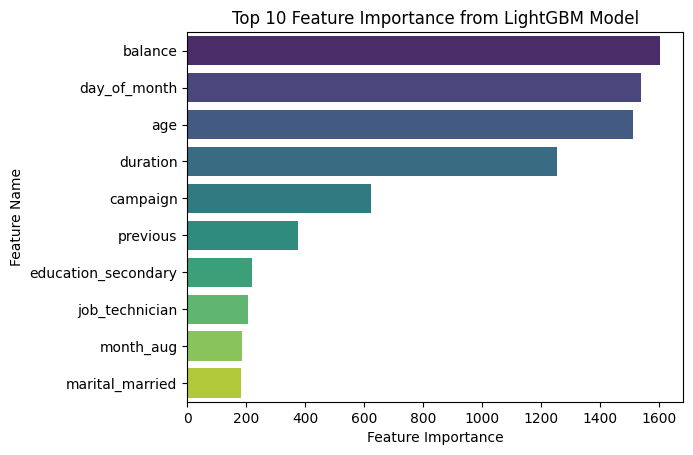

In [ ]:
# Obtain the feature importance of the LightGBM model
feature_importance_lightGBM = model_lightGBM.feature_importances_

# List the feature names of the LightGBM model
feature_names = ['age', 'balance', 'duration', 'campaign', 'pcontact', 'previous', 'day_of_month', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'marital_married', 'marital_single', 'education_secondary', 'education_tertiary', 'default_yes', 'housing_yes', 'loan_yes', 'contact_telephone', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_success']

# Sort out the top 10 feature importance and names
sorted_idx = np.argsort(feature_importance_lightGBM)
top10_idx = sorted_idx[-10:]
top10_importance = feature_importance_lightGBM[top10_idx]
top10_names = np.array(feature_names)[top10_idx]

# Adjust the order for visualization
sorted_idx = np.argsort(top10_importance)[::-1]

# Visualize the features with the top 10 importance
sns.barplot(x=top10_importance[sorted_idx], y=top10_names[sorted_idx], palette="viridis")
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Top 10 Feature Importance from LightGBM Model')
plt.show()

In this visualization, we can observe the top 10 features contributing most to the predictions of the lightGBM model. 'Balance' (1602), 'day_of_month' (1539), 'age' (1513), and 'duration' (1253) are the top four features, with importance values all exceeding 1200. Features ranked 5-10 have importance values below 800.

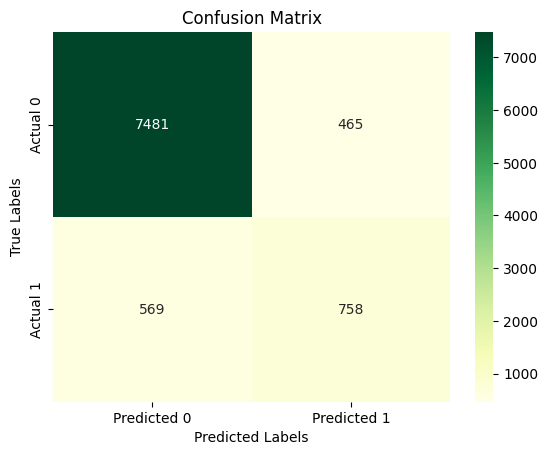

In [ ]:
# Calculate the confusion matrix for the LightGBM model
cm = confusion_matrix(y_test, y_pred_test)

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap=sns.color_palette("YlGn", as_cmap=True),
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'], cbar=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

The confusion matrix informs us that there are 758 samples classified as True Positive, 7481 samples as True Negative, 465 samples as False Positive, and 569 samples as False Negative. This indicates that the number of correct predictions made by the lightGBM model is significantly higher than the number of incorrect predictions.

In [ ]:
# Get predicted probabilities for the positive class
y_scores = model_lightGBM.predict_proba(X_test_lightGBM)[:, 1]

# Compute ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve values
precision, recall, _ = precision_recall_curve(y_test, y_scores)
pr_auc = average_precision_score(y_test, y_scores)

# Create subplot layout
fig = make_subplots(rows=1, cols=2,
                    subplot_titles=('Receiver Operating Characteristic Curve', 'Precision-Recall Curve'))

# ROC curve
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name='ROC curve (AUC = {:.2f})'.format(roc_auc)), row=1, col=1)
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random Classifier', line=dict(dash='dash')), row=1, col=1)
fig.update_xaxes(title_text="False Positive Rate", row=1, col=1)
fig.update_yaxes(title_text="True Positive Rate", row=1, col=1)

# Precision-Recall curve
fig.add_trace(go.Scatter(x=recall, y=precision, mode='lines', name='PR curve (AUC = {:.2f})'.format(pr_auc)), row=1, col=2)
fig.update_xaxes(title_text="Recall", row=1, col=2)
fig.update_yaxes(title_text="Precision", row=1, col=2)

# Update the layout and displaying the plot
fig.update_layout(showlegend=True)
fig.show()

[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=13 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] feature_fraction is set=0.4708420236563549, colsample_bytree=0.39626924590389834 will be ignored. Current value: feature_fraction=0.4708420236563549
[LightGBM] [Warning] bagging_fraction is set=0.9985796175995465, subsample=0.5892173036332047 will be ignored. Current value: bagging_fraction=0.9985796175995465
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


We can observe that the ROC curve of the lightGBM model leans towards the upper-left corner of the (0,1) coordinates. The True Positive rate, moving from left to right, remains higher than the False Positive rate, ultimately intersecting at the point (1,1). This indicates excellent performance of the classifier. In addition, the AUC is 0.92, very close to 1, once again confirming the performance of our classifier.

The Precision-Recall Curve approaches the upper-right corner (1,1), indicating that the lightGBM model achieves a good balance between high precision and high recall when dealing with imbalanced datasets. Meanwhile, the AUC has reached 0.63, reaffirming the good performance of our model.

# 4. Model Results & Business Insights

## 4.1 SHAP Summary Plot

In [ ]:
feature_map = {
    0: 'age', 1: 'balance', 2: 'duration', 3: 'campaign', 4: 'pcontact', 5: 'previous',
    6: 'day_of_month', 7: 'job_blue-collar', 8: 'job_entrepreneur', 9: 'job_housemaid',
    10: 'job_management', 11: 'job_retired', 12: 'job_self-employed', 13: 'job_services',
    14: 'job_student', 15: 'job_technician', 16: 'job_unemployed', 17: 'marital_married',
    18: 'marital_single', 19: 'education_secondary', 20: 'education_tertiary',
    21: 'default_yes', 22: 'housing_yes', 23: 'loan_yes', 24: 'contact_telephone',
    25: 'month_aug', 26: 'month_dec', 27: 'month_feb', 28: 'month_jan', 29: 'month_jul',
    30: 'month_jun', 31: 'month_mar', 32: 'month_may', 33: 'month_nov', 34: 'month_oct',
    35: 'month_sep', 36: 'poutcome_success'
}

# Assuming 'lightGBM_feature_indices' is a list of indices of features used in your model
feature_names = [feature_map[idx] for idx in lightGBM_feature_indices]

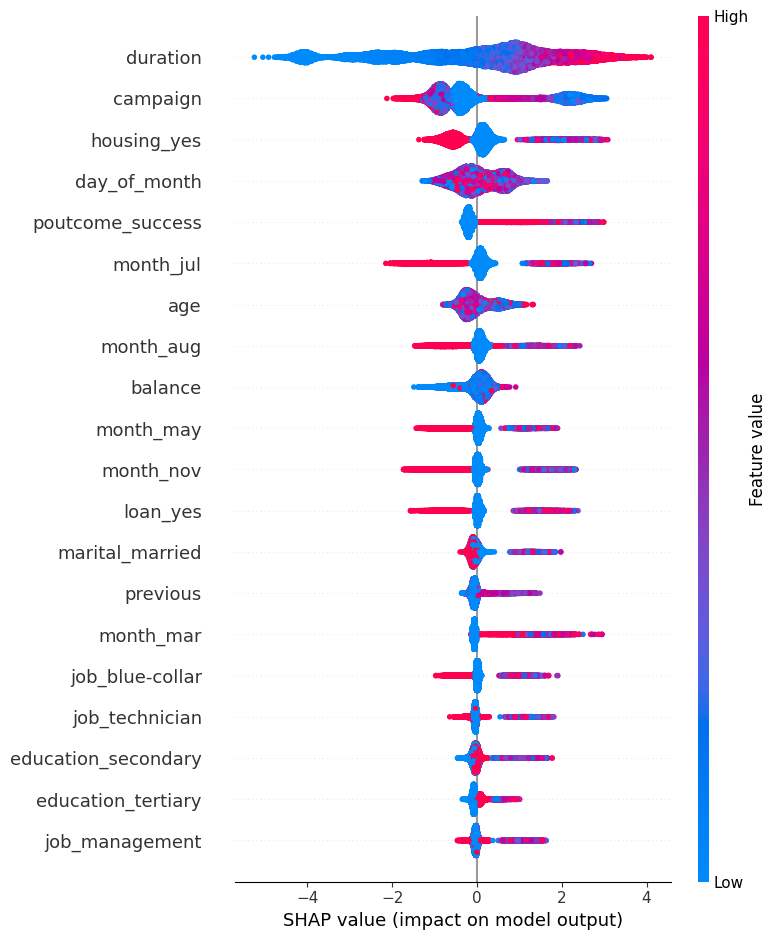

In [ ]:
shap.summary_plot(shap_values[1], X_resampled[:, lightGBM_feature_indices], feature_names=feature_names)

In [ ]:
# Generate SHAP Values
explainer = shap.TreeExplainer(model_lightGBM)
shap_values = explainer.shap_values(X_resampled[:, lightGBM_feature_indices])

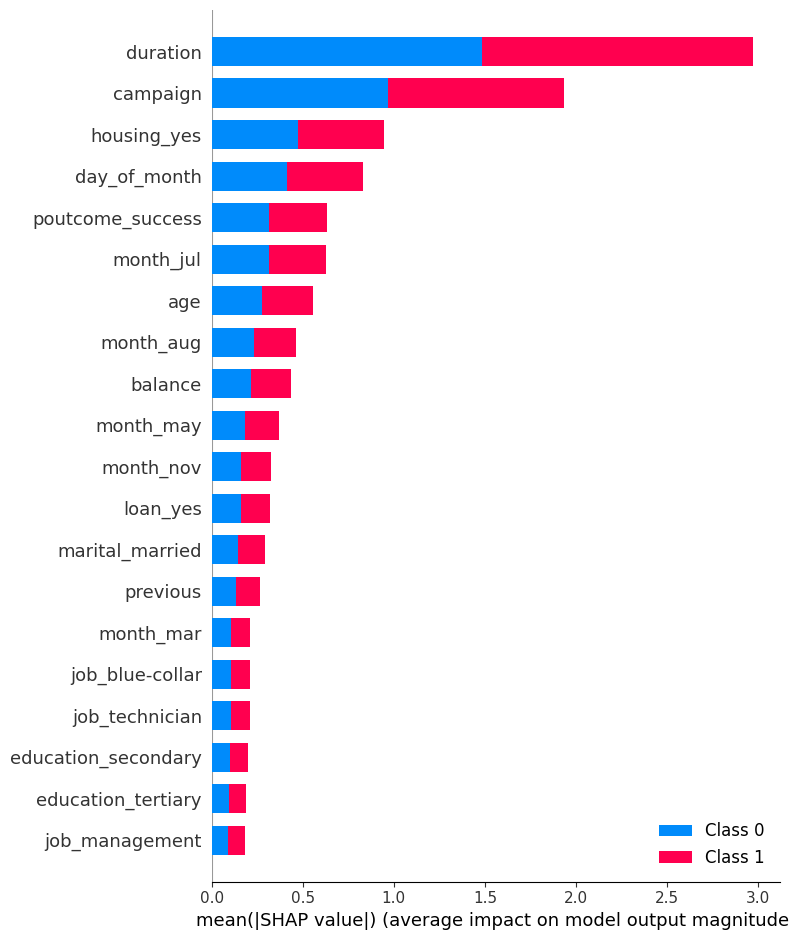

In [ ]:
shap.summary_plot(shap_values, X_resampled[:, lightGBM_feature_indices], feature_names=feature_names, plot_type="bar")

Observations:


*   `Duration`: this is the most impactful feature since its Higher values (shown in red) have a strong positive impact on the model's output, suggesting that longer call durations are strongly associated with successful outcomes.

*   `Campaign`: This feature has a mix of positive and negative impacts on the model's output.

*   `Poutcome_success`: This feature represents the outcome of the previous marketing campaign. Success in the previous campaign (which is represented by color of red) has a positive impact on the model's output, indicating that previous success is a strong predictor of future success.

*   `Month_jul`, `month_aug`, `month_may`, `month_nov`: These features represent the month of the year when the last contact was made. It seems that contacts made in May, July, August and November have a strong negative impact on the model's results as they are shown in red to the left in this shap plot, meaning that they had negatively influence campaign success, suggesting timing within the year is a  crucial factor the bank need to consider.

## 4.2 SHAP Scatter Plot

The key features we want to plot SHAP values are `duration`, `campaign`, and `balance`.

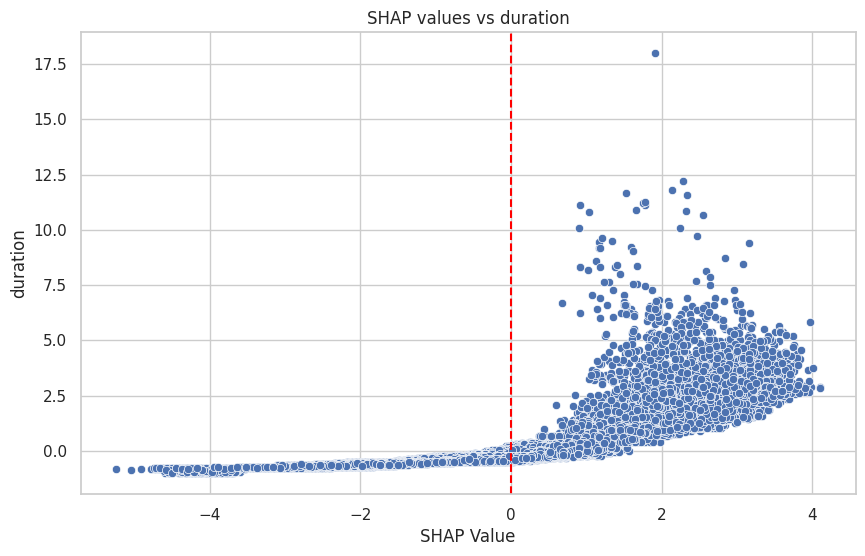

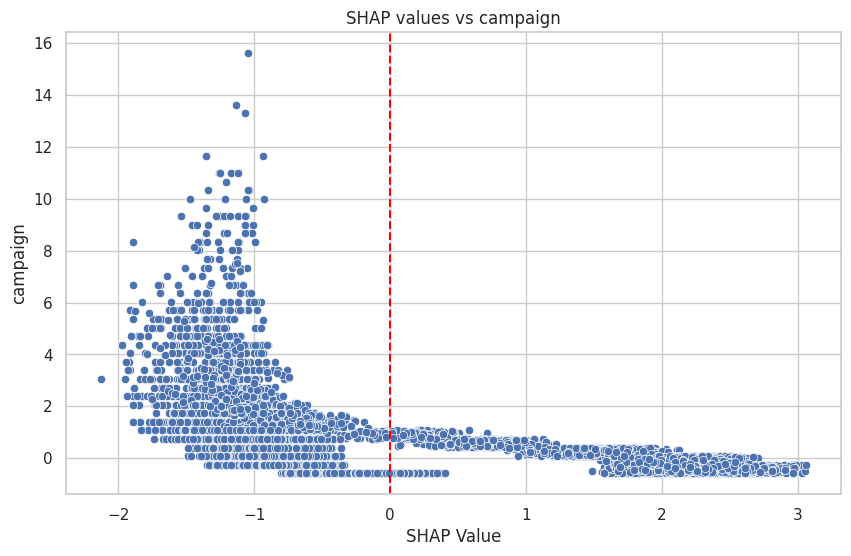

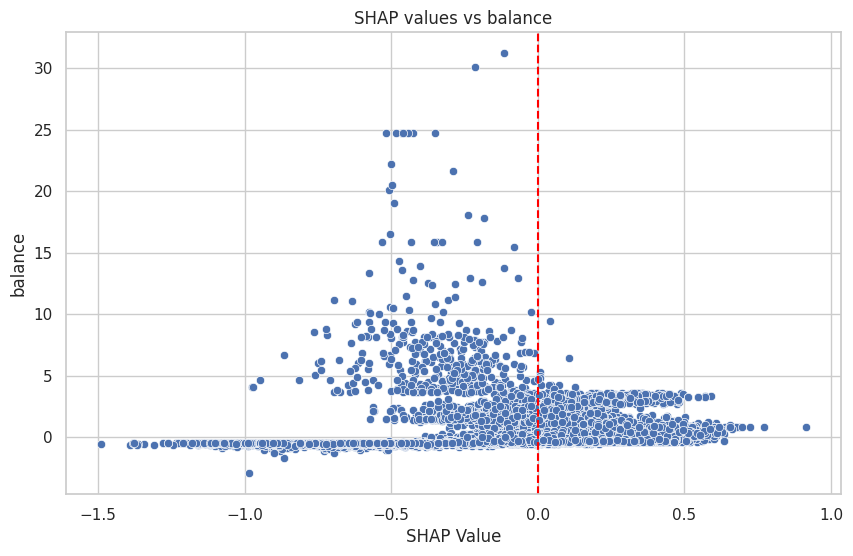

In [ ]:
# List of features for which you want to plot SHAP values
features_to_plot = ['duration', 'campaign', 'balance']

# Setting up Seaborn
sns.set(style="whitegrid")

# Plotting SHAP values for each feature using Seaborn
for feature in features_to_plot:
    idx = feature_names.index(feature)

    # Extract SHAP values and feature values
    shap_vals = shap_values[1][:, idx]
    feature_vals = X_resampled[:, lightGBM_feature_indices][:, idx]

    # Create a DataFrame for easier plotting
    data = pd.DataFrame({'SHAP Value': shap_vals, feature: feature_vals})

    # Create scatter plot with flipped axes
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='SHAP Value', y=feature, data=data)

    # Add a vertical red dashed line at SHAP value = 0
    plt.axvline(x=0, color='red', linestyle='--')

    plt.title(f'SHAP values vs {feature}')
    plt.show()


# 5. Conclusion & Recommendations

*   `Duration`--This is the most impactful feature since its higher SHAP value, as shown in red in summary plot, duration of last contact call have a strong positive impact on the model's output, suggesting that longer call durations are strongly associated with successful outcomes. The scatter plot better illustrates the point further and when the duration of calls is greater than zero, it will generally have a positive impact on the predictive model's outcome.
*   `Campaign`--The SHAP Value vs Campaign plot suggests that in the context of bank telemarketing, engaging a client with too many contacts could potentially decrease the likelihood of a successful outcome. The thing we wanted to highlighted is the importance of optimizing the number of touch points with customers. As this being said, we suggest that bank could benefit from focusing on the quality rather than the quantity of interactions with customers, perhaps by investing in understanding the ideal frequency of contact for different customer segments to enhance the over effectiveness of its telemarketing campaigns.
*   `Balance`--The scatter plot of SHAP Value vs Balance indicates how the average amount of money customers have in their bank accounts affects our predictions about who will respond to our marketing efforts. For customers with lower balances, the direction of influence is ambiguous, with SHAP values remaining close to the starting line of zero, suggesting an indistinct impact. On the other hand, as account balances goes higher, the data reveals a negative influence on our predictions, implying a more intricate relationship where a higher balance could be associated with a decreased likelihood of a positive response.